In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time 
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
from dataset import *
from utils import *
from train import *
from torch.utils.tensorboard import SummaryWriter
from os import path as osp

In [3]:
from arabert.preprocess import ArabertPreprocessor
import pyarabic.araby as araby


model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

[2021-09-28 23:38:17,088 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# Model with Arabert Preprocessing to old processing

In [4]:
DATA_JSON_PATH = 'sm_ar_data.json'
IMGS_PATH = 'images_200/'
DATA_NAME = 'TESTING'

In [5]:
max_seq = 65
vocab = build_vocab('data/ar_data.json', max_seq=max_seq)
vocab_len = len(vocab); vocab_len

100%|██████████| 24000/24000 [00:00<00:00, 290055.83it/s]


3309

In [6]:
print(list(vocab.itos.keys())[:10]) 
print(list(vocab.itos.values())[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['<pad>', '<sos>', '<eos>', '<unk>', '+', 'ة', 'طفل', 'صغير', 'تتسلق', 'إلى']


In [7]:
m = load_checkpoint("ar_models/BEST_checkpoint_flickr8k_ar_arabert_finetune.pth.tar")

Loaded Checkpoint!!
Last Epoch: 17
Best Bleu-4: 25.49970489970383


In [8]:
encoder = m['encoder'].eval()
decoder = m['decoder'].eval()

In [9]:
from eval import test_score

test_dict = {}

for i in range(1, 6):
    
    b1, b2, b3, b4 = test_score(i, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab)
    if i == 3:
        test_dict['b1'] = b1
        test_dict['b2'] = b2
        test_dict['b3'] = b3
    
    test_dict[f'b4-b{i}'] = b4

Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 1:   0%|          | 0/201 [00:00<?, ?it/s]/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/Bi

----- Bleu-n Scores -----
1: 57.318
2: 44.160
3: 31.607
4: 22.547
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 2: 100%|██████████| 201/201 [00:09<00:00, 20.35it/s]


----- Bleu-n Scores -----
1: 57.529
2: 45.336
3: 33.089
4: 24.017
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 3: 100%|██████████| 201/201 [00:10<00:00, 19.63it/s]


----- Bleu-n Scores -----
1: 59.589
2: 47.828
3: 35.584
4: 26.296
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 4: 100%|██████████| 201/201 [00:12<00:00, 16.50it/s]


----- Bleu-n Scores -----
1: 60.308
2: 48.322
3: 35.485
4: 26.241
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 5: 100%|██████████| 201/201 [00:13<00:00, 14.42it/s]

----- Bleu-n Scores -----
1: 59.506
2: 47.864
3: 35.466
4: 26.170
-------------------------


In [10]:
references, hypotheses = test_score(3, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab, return_results=True)

Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 3: 100%|██████████| 201/201 [00:10<00:00, 18.80it/s]


----- Bleu-n Scores -----
1: 59.589
2: 47.828
3: 35.584
4: 26.296
-------------------------


In [11]:
references_ara_tokens = [[[vocab.itos[i] for i in refe] for refe in refes] for refes in references]
hypotheses_ara_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypotheses]

In [12]:
references_sent_tokens = [[arabert_prep.unpreprocess(' '.join(w for w in i)) for i in refe] for refe in references_ara_tokens] 
hypotheses_sent_tokens = [arabert_prep.unpreprocess(' '.join(w for w in i)) for i in hypotheses_ara_tokens]

In [13]:
references_old_tokens = [[araby.tokenize(i)  for i in refe] for refe in references_sent_tokens] 
hypotheses_old_tokens = [araby.tokenize(i)  for i in hypotheses_sent_tokens]

In [14]:
print_scores(references_old_tokens, hypotheses_old_tokens)

----- Bleu-n Scores -----
1: 20.850
2: 11.913
3: 5.706
4: 2.834
-------------------------


(20.85, 11.913, 5.706, 2.834)

# Model with old preprocessing to Arabert 

In [15]:
DATA_JSON_PATH = 'sm_old_data.json'
IMGS_PATH = 'images_200/'

In [16]:
max_seq = 30
vocab = build_vocab('old_ar_data.json', max_seq=max_seq)
vocab_len = len(vocab); vocab_len

100%|██████████| 24000/24000 [00:00<00:00, 392542.85it/s]


5788

In [17]:
print(list(vocab.itos.keys())[:10])
print(list(vocab.itos.values())[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['<pad>', '<sos>', '<eos>', '<unk>', 'طفلة', 'صغيرة', 'تتسلق', 'إلى', 'كلب', 'أسود']


In [18]:
m = load_checkpoint("models/BEST_checkpoint_flickr8k_ar_finetune.pth.tar")

Loaded Checkpoint!!
Last Epoch: 19
Best Bleu-4: 6.862300456763069


In [19]:
encoder = m['encoder'].eval()
decoder = m['decoder'].eval()

In [20]:
from eval import test_score

for i in range(1, 10):
    b1, b2, b3, b4 = test_score(i, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab)

Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 1: 100%|██████████| 201/201 [00:05<00:00, 35.24it/s]


----- Bleu-n Scores -----
1: 32.438
2: 18.206
3: 9.580
4: 4.769
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 2: 100%|██████████| 201/201 [00:06<00:00, 31.06it/s]


----- Bleu-n Scores -----
1: 31.200
2: 18.209
3: 10.695
4: 6.155
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 3: 100%|██████████| 201/201 [00:06<00:00, 29.66it/s]


----- Bleu-n Scores -----
1: 29.399
2: 17.839
3: 10.332
4: 5.624
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 4: 100%|██████████| 201/201 [00:08<00:00, 24.93it/s]


----- Bleu-n Scores -----
1: 29.092
2: 17.522
3: 10.122
4: 5.572
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 5: 100%|██████████| 201/201 [00:08<00:00, 23.89it/s]


----- Bleu-n Scores -----
1: 29.474
2: 18.720
3: 11.352
4: 6.647
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 6: 100%|██████████| 201/201 [00:08<00:00, 23.80it/s]


----- Bleu-n Scores -----
1: 30.284
2: 19.220
3: 11.792
4: 6.848
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 7: 100%|██████████| 201/201 [00:09<00:00, 22.33it/s]


----- Bleu-n Scores -----
1: 28.765
2: 18.126
3: 11.146
4: 6.598
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 8: 100%|██████████| 201/201 [00:09<00:00, 20.75it/s]


----- Bleu-n Scores -----
1: 27.838
2: 17.593
3: 10.837
4: 6.478
-------------------------
Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 9: 100%|██████████| 201/201 [00:10<00:00, 20.03it/s]


----- Bleu-n Scores -----
1: 26.872
2: 16.970
3: 10.359
4: 6.029
-------------------------


In [21]:
references, hypotheses = test_score(6, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab, return_results=True)

Dataset split: test
Unique images: 201
Total size: 1005


EVALUATING AT BEAM SIZE 6: 100%|██████████| 201/201 [00:08<00:00, 24.15it/s]


----- Bleu-n Scores -----
1: 30.284
2: 19.220
3: 11.792
4: 6.848
-------------------------


In [22]:
references_old_tokens = [[[vocab.itos[i] for i in refe] for refe in refes] for refes in references]
hypotheses_old_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypotheses]

In [23]:
hypotheses_ara_tokens = [araby.tokenize(arabert_prep.preprocess(" ".join(i))) for i in hypotheses_old_tokens]
references_ara_tokens = [[araby.tokenize(arabert_prep.preprocess(" ".join(i))) for i in ref] for ref in references_old_tokens]

In [24]:
print_scores(references_ara_tokens, hypotheses_ara_tokens)

----- Bleu-n Scores -----
1: 52.961
2: 43.629
3: 35.132
4: 28.185
-------------------------


(52.961, 43.629, 35.132, 28.185)

# Saving Predictions info
- Ground Truth Captions [separete df]
- Araby Catpions and Arabert captions with their number of tokens (print the number of words later)

In [25]:
import pandas as pd 
df = pd.read_json('sm_ar_data.json')
ground_truth = df[df['split'] == 'test'].drop(['split', 'tokens', 'tok_len'], axis=1)
ground_truth.head()

,caption,file_name
0,الناس يعبرون الشارع في بلدة صينية مزدحمة.,000000064183.jpg
1,شخص يحمل مظلة صفراء يمشي بالقرب من الرصيف.,000000064183.jpg
2,شخص في الشارع يجر عربة تسوق ويحمل مظلة.,000000064183.jpg
3,امرأة في شارع مزدحم مع عربة تسوق ومظلة.,000000064183.jpg
4,أشخاص يسيرون وسيارات تسير في شارع بجوار متاجر,000000064183.jpg


In [26]:
ground_truth.shape

(1005, 2)

## Old Predictions 

In [27]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from caption import CaptionDataset, caption_image
from utils import load_checkpoint, print_scores
from dataset import build_vocab
import pandas as pd
from tqdm import tqdm

In [28]:
model_path = 'models/BEST_checkpoint_flickr8k_ar_finetune.pth.tar'
IMGS_PATH = 'images_200/'
DATA_JSON_PATH = 'sm_old_data.json'

In [29]:
vocab = build_vocab('old_ar_data.json')
print('len:',len(vocab))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


bs = 1
loader = DataLoader(
            dataset=CaptionDataset(IMGS_PATH, DATA_JSON_PATH,
                                    transforms=transform, vocab=vocab, split='test'),
            batch_size=bs,
            num_workers=7,
            pin_memory=True
        )

print('-'*20)
checkpoint = load_checkpoint(model_path)
encoder = checkpoint['encoder'].eval()
decoder = checkpoint['decoder'].eval()

100%|██████████| 24000/24000 [00:00<00:00, 384021.97it/s]


len: 5788
Dataset split: test
Unique images: 201
Total size: 1005
--------------------
Loaded Checkpoint!!
Last Epoch: 19
Best Bleu-4: 6.862300456763069


In [30]:
references, hypothesis, img_ids = caption_image(loader, vocab, encoder,
                                               decoder, 6)

EVALUATING AT BEAM SIZE 6: 100%|██████████| 201/201 [00:08<00:00, 23.70it/s]

Number of NO COMPLETED:  0


In [31]:
hypotheses_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypothesis]

In [32]:
df = pd.DataFrame.from_dict({"file_name":img_ids, "old_hypotheses": hypotheses_tokens})
df.head()

,file_name,old_hypotheses
0,000000064183.jpg,"[رجل, يرتدي, سترة, صفراء]"
1,000000065288.jpg,"[اثنين, من, الكلاب, يلعبون, في, الثلج]"
2,000000144000.jpg,"[مجموعة, من, الناس, يلعبون, كرة, القدم]"
3,000000323789.jpg,"[رجل, يجلس, على, مقعد]"
4,000000416098.jpg,"[رجل, يركب, دراجة, هوائية]"


In [33]:
df['old_tok_len'] = df['old_hypotheses'].apply(lambda x: len(x)).values
df.head()

,file_name,old_hypotheses,old_tok_len
0,000000064183.jpg,"[رجل, يرتدي, سترة, صفراء]",4
1,000000065288.jpg,"[اثنين, من, الكلاب, يلعبون, في, الثلج]",6
2,000000144000.jpg,"[مجموعة, من, الناس, يلعبون, كرة, القدم]",6
3,000000323789.jpg,"[رجل, يجلس, على, مقعد]",4
4,000000416098.jpg,"[رجل, يركب, دراجة, هوائية]",4


### Arabert Predictions 

In [34]:
model_path = 'ar_models/BEST_checkpoint_flickr8k_ar_arabert_pretrained_finetune.pth.tar'
IMGS_PATH = 'images_200/'
DATA_JSON_PATH = 'sm_ar_data.json'

In [35]:
vocab = build_vocab('data/ar_data.json')
print('len:',len(vocab))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


bs = 1
loader = DataLoader(
            dataset=CaptionDataset(IMGS_PATH, DATA_JSON_PATH,
                                    transforms=transform, vocab=vocab, split='test'),
            batch_size=bs,
            num_workers=7,
            pin_memory=True
        )

print('-'*20)
checkpoint = load_checkpoint(model_path)
encoder = checkpoint['encoder'].eval()
decoder = checkpoint['decoder'].eval()

100%|██████████| 24000/24000 [00:00<00:00, 240327.40it/s]


len: 3309
Dataset split: test
Unique images: 201
Total size: 1005
--------------------
Loaded Checkpoint!!
Last Epoch: 9
Best Bleu-4: 24.949378413361714


In [36]:
references, hypothesis, img_ids = caption_image(loader, vocab, encoder,
                                               decoder, 3)
hypotheses_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypothesis]

EVALUATING AT BEAM SIZE 3: 100%|██████████| 201/201 [00:10<00:00, 19.45it/s]

Number of NO COMPLETED:  3


In [37]:
rest_df = pd.DataFrame.from_dict({"file_name":img_ids, "hypotheses": hypotheses_tokens})
rest_df.head()

,file_name,hypotheses
0,000000064183.jpg,"[امرأ, +, ة, في, ال, +, شارع]"
1,000000065288.jpg,"[كلب, يقفز, في, ال, +, هواء]"
2,000000144000.jpg,"[مجموع, +, ة, من, ال, +, ناس, في, ال, +, شارع]"
3,000000323789.jpg,"[صبي, صغير, يرتدي, قميص, +, ا, أحمر, و, +, ال,..."
4,000000416098.jpg,"[رجل, يركب, دراج, +, ة, في, ال, +, هواء]"


In [38]:
rest_df['tok_len'] = rest_df['hypotheses'].apply(lambda x: len(x)).values
rest_df.head()

,file_name,hypotheses,tok_len
0,000000064183.jpg,"[امرأ, +, ة, في, ال, +, شارع]",7
1,000000065288.jpg,"[كلب, يقفز, في, ال, +, هواء]",6
2,000000144000.jpg,"[مجموع, +, ة, من, ال, +, ناس, في, ال, +, شارع]",11
3,000000323789.jpg,"[صبي, صغير, يرتدي, قميص, +, ا, أحمر, و, +, ال,...",39
4,000000416098.jpg,"[رجل, يركب, دراج, +, ة, في, ال, +, هواء]",9


In [39]:
rest_df['file_name'].nunique()

198

In [40]:
full_df = df.merge(rest_df, on='file_name')
print(full_df.shape)
full_df.sample(20)

(198, 5)


,file_name,old_hypotheses,old_tok_len,hypotheses,tok_len
78,000000231034.jpg,"[رجل, يجلس, على, مقعد]",4,"[امرأ, +, ة, صغير, +, ة, صغير, +, ة, في, ال, +...",13
196,000000580172.jpg,"[رجل, في, قميص, أصفر]",4,"[ال, +, كلب, ال, +, بني, و, +, ال, +, أسود, و,...",21
87,000000176029.jpg,"[سيارة, سباق, <unk>]",3,"[سيار, +, ة, من, ال, +, ناس, في, ال, +, شارع]",11
111,000000021993.jpg,"[رجل, يجلس, على, مقعد]",4,"[رجل, يرتدي, قميص, +, ا, أحمر, و, +, ال, +, أس...",15
48,000000356396.jpg,"[رجل, يقف, في, الشارع]",4,"[سيار, +, ة, من, ال, +, ناس, في, ال, +, شارع]",11
165,000000569314.jpg,"[مجموعة, من, الناس, يجلسون, على, طاولة]",6,"[طفل, +, ان, يلعب, +, ان, في, ال, +, هواء]",10
157,000000346384.jpg,"[الناس, في, الشارع]",3,"[ال, +, ناس, في, ال, +, شارع]",7
28,000000465911.jpg,"[صبي, صغير, يقفز, في, الهواء]",5,"[صبي, صغير, يقفز, في, ال, +, هواء]",7
94,000000319943.jpg,"[راكب, أمواج, يركب, موجة]",4,"[راكب, ال, +, أمواج, في, ال, +, ماء]",8
181,000000172989.jpg,"[رجل, يقف, في, الثلج]",4,"[رجل, يقف, على, ال, +, ثلج]",6


In [41]:
full_df['old_captions'] = full_df.old_hypotheses.apply(lambda x: " ".join(i for i in x)).values
full_df['captions'] = full_df.hypotheses.apply(lambda x: arabert_prep.unpreprocess(' '.join(w for w in x))).values
full_df.head()

,file_name,old_hypotheses,old_tok_len,hypotheses,tok_len,old_captions,captions
0,000000064183.jpg,"[رجل, يرتدي, سترة, صفراء]",4,"[امرأ, +, ة, في, ال, +, شارع]",7,رجل يرتدي سترة صفراء,امرأة في الشارع
1,000000065288.jpg,"[اثنين, من, الكلاب, يلعبون, في, الثلج]",6,"[كلب, يقفز, في, ال, +, هواء]",6,اثنين من الكلاب يلعبون في الثلج,كلب يقفز في الهواء
2,000000144000.jpg,"[مجموعة, من, الناس, يلعبون, كرة, القدم]",6,"[مجموع, +, ة, من, ال, +, ناس, في, ال, +, شارع]",11,مجموعة من الناس يلعبون كرة القدم,مجموعة من الناس في الشارع
3,000000323789.jpg,"[رجل, يجلس, على, مقعد]",4,"[صبي, صغير, يرتدي, قميص, +, ا, أحمر, و, +, ال,...",39,رجل يجلس على مقعد,صبي صغير يرتدي قميصا أحمر واللون الأحمر واللون...
4,000000416098.jpg,"[رجل, يركب, دراجة, هوائية]",4,"[رجل, يركب, دراج, +, ة, في, ال, +, هواء]",9,رجل يركب دراجة هوائية,رجل يركب دراجة في الهواء


# Saving individual BLEU scores 

In [42]:
def calculate_scores(row):
    idx = ["old processing, old results", "new processing, new results", "new processing, old results", "old processing, new results"]
    b1s = []
    b2s = []
    b3s = []
    b4s = []
    
    # get ground truth 
    gt = ground_truth[ground_truth.file_name == row['file_name']].caption.values
    
    # tokenize truth
    old_tokens_truth = [araby.tokenize(i) for i in gt]
    tokens_truth = [araby.tokenize(arabert_prep.preprocess(i)) for i in gt]
    

    b1, b2, b3, b4 = print_scores([old_tokens_truth], [row['old_hypotheses']], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)

    b1, b2, b3, b4 = print_scores([tokens_truth], [row['hypotheses']], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    # reverse scores
    old_hypo = araby.tokenize(arabert_prep.preprocess(row['old_captions']))
    hypo = araby.tokenize(row['captions'])
    
    b1, b2, b3, b4 = print_scores([tokens_truth], [old_hypo], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    b1, b2, b3, b4 = print_scores([old_tokens_truth], [hypo], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    out_df = pd.DataFrame({'Exp': idx, 'b1': b1s, 'b2': b2s, 'b3': b3s, 'b4': b4s})
    gt_df = ground_truth[ground_truth.file_name == row['file_name']].drop('file_name', axis=1)
    return pd.concat([d.reset_index(drop=True) for d in [out_df, gt_df]], axis=1).fillna('_')

In [43]:
calculate_scores(full_df.iloc[0])

/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

,Exp,b1,b2,b3,b4,caption
0,"old processing, old results",9.197,0,0,0,الناس يعبرون الشارع في بلدة صينية مزدحمة.
1,"new processing, new results",27.645,27.645,25.664,21.986,شخص يحمل مظلة صفراء يمشي بالقرب من الرصيف.
2,"new processing, old results",9.444,8.447,6.958,0,شخص في الشارع يجر عربة تسوق ويحمل مظلة.
3,"old processing, new results",18.888,18.888,0,0,امرأة في شارع مزدحم مع عربة تسوق ومظلة.
4,_,_,_,_,_,أشخاص يسيرون وسيارات تسير في شارع بجوار متاجر


In [44]:
full_df.to_json('results_comparison_200.json')

# Comparing Results 

In [45]:
# Modules
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt

import os, shutil

# needed to use matplotlib with jupyter widgets
%matplotlib notebook

from IPython.display import display, clear_output

In [46]:
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>


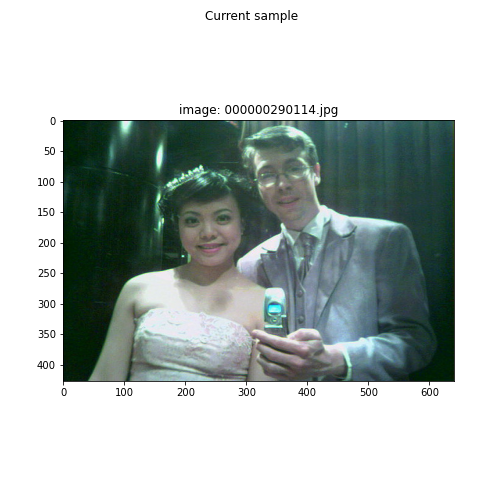

In [47]:
# Create the widgets
left = widgets.Button(description='Left')
right = widgets.Button(description='Right')
out = widgets.Output()

# get the file names
DATA_PATH = 'images_200/'
full_df = pd.read_json('results_comparison_200.json')

# Setting the first and last indexs
i=0 # starting index
i_max = full_df.shape[0] # ending index

# Plot the first picture
img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
fig, ax = plt.subplots(1, figsize=(7, 7))
ax = plt.imshow(img)
plt.suptitle("Current sample")
plt.show()
with out:
    clear_output()
    display(full_df.iloc[i:i+1].drop('file_name', axis=1))
    display(calculate_scores(full_df.iloc[i]))

# plots the next image
def plot_next(*args):
    global i
    i += 1
    # stop
    if i >= i_max: 
        print("Done")
        return

    
    # get next image index
    img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
    ax.set_data(img)
    plt.show()
    plt.title(f"image: {full_df.iloc[i, 0]}")
    with out:
        clear_output()
        display(full_df.iloc[i:i+1].drop('file_name', axis=1))
        display(calculate_scores(full_df.iloc[i]))

def plot_previous(*args):
    global i
    i -= 1
    # stop
    if i < 0: 
        print("Done")
        return

    
    
    # get next image index
    img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
    ax.set_data(img)
    plt.show()
    plt.title(f"image: {full_df.iloc[i, 0]}")

    with out:
        clear_output()
        display(full_df.iloc[i:i+1].drop('file_name', axis=1))
        display(calculate_scores(full_df.iloc[i]))
    
    
# attaching the buttons to their callback functions         
right.on_click(plot_next)
left.on_click(plot_previous)

# showing the widgets
vb1 = widgets.VBox([right, left])
vb2 = widgets.VBox([out])
widgets.HBox([vb1, vb2])